# Imports & Load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2
%matplotlib inline

sns.set()
sns.set_palette('Pastel2')
SNS_CMAP = 'Pastel2'
colors = sns.palettes.color_palette(SNS_CMAP)
pd.options.mode.chained_assignment = None

dataset @ https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [11]:
#if dataset locally available
# df = pd.read_csv(os.path.join(DATA_DIR, "IMDB Dataset.csv"))

#else load data from kaggle
import kagglehub
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
df = pd.read_csv(os.path.join(path, "IMDB Dataset.csv"))

In [12]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


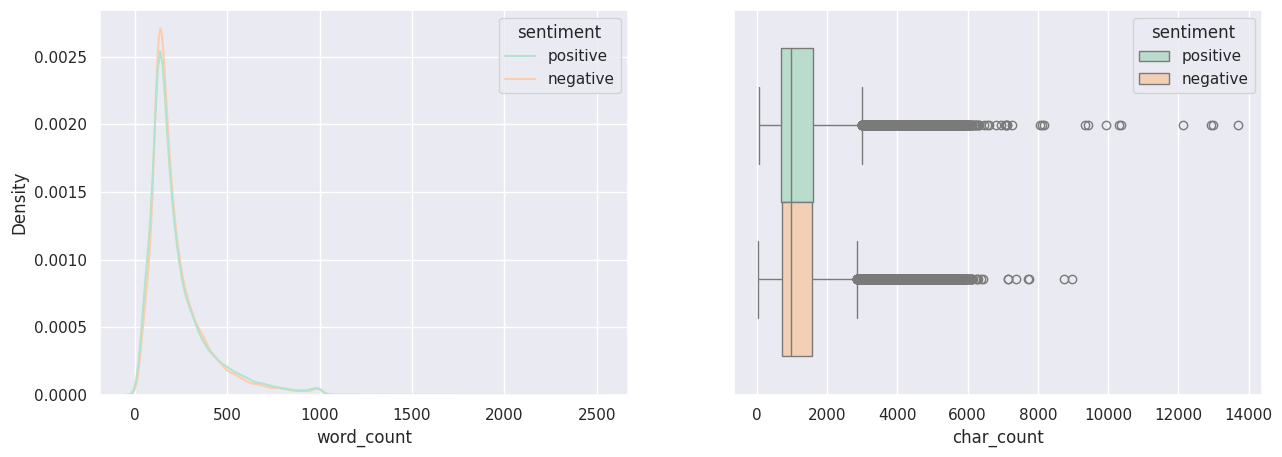

In [5]:
dfv = df.copy()
dfv["word_count"] = dfv["review"].apply(lambda x: len(x.split()))
dfv["char_count"] = dfv["review"].apply(lambda x: len(x))
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.kdeplot(data=dfv, x='word_count', hue='sentiment', ax=ax[0])
sns.boxplot(data=dfv, x='char_count', hue='sentiment', ax=ax[1])
plt.show()

# Preprocessing

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [14]:
def clean_text(txt:str)->str:
  txt = re.sub(r'<.*?>', '', txt)
  txt = re.sub(r'[^a-z\s]', '', txt)
  tokens = txt.split()
  tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
  return ' '.join(tokens)[:2000]

df['review'] = df['review'].apply(clean_text)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1024)
X = vectorizer.fit_transform(df["review"])
X = X.toarray()

In [22]:
y = df['sentiment'].map({
    "positive": 0,
    "negative": 1,
}).values

X.shape, y.shape

((50000, 1024), (50000,))

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40000, 1024), (10000, 1024), (40000,), (10000,))

# Binary Classification with Neural Net

In [24]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [25]:
model = keras.Sequential([
    layers.Input(shape=(1024,)),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
    )

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 278,913 (1.06 MB)

 Trainable params: 278,913 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
hist = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7815 - loss: 0.4537 - val_accuracy: 0.8491 - val_loss: 0.3406
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8646 - loss: 0.3187 - val_accuracy: 0.8468 - val_loss: 0.3450
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8850 - loss: 0.2761 - val_accuracy: 0.8476 - val_loss: 0.3437
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9193 - loss: 0.2180 - val_accuracy: 0.8396 - val_loss: 0.3749
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9537 - loss: 0.1375 - val_accuracy: 0.8404 - val_loss: 0.4410
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9737 - loss: 0.0804 - val_accuracy: 0.8413 - val_loss: 0.5202
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9855 - loss: 0.0463 - val_accuracy: 0.8390 - val_loss: 0.5670
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9872 - loss: 0.0382

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


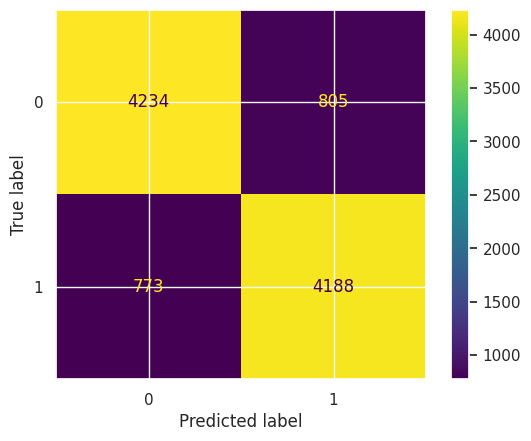

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_logits = model.predict(X_test)
y_pred = (y_pred_logits > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()


In [32]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84      5039
           1       0.84      0.84      0.84      4961

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

